In [2]:

import imagesize # get image sizes without loading them into memory
import os
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown, display
import random
from PIL import Image

import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms.v2 import Compose, Resize, ToImage, ToDtype

from model_architecture import Model

# Wstępna eksploracja zbioru danych

### Sprawdźmy Ilość obserwacji na daną klasę

In [3]:
# path to training directory
PATH = os.path.join(os.getcwd(), "train")


class_sizes = []
for class_dir in os.listdir(PATH):
    class_sizes.append(len(os.listdir(os.path.join(PATH, class_dir))))

class_sizes = np.array(class_sizes)

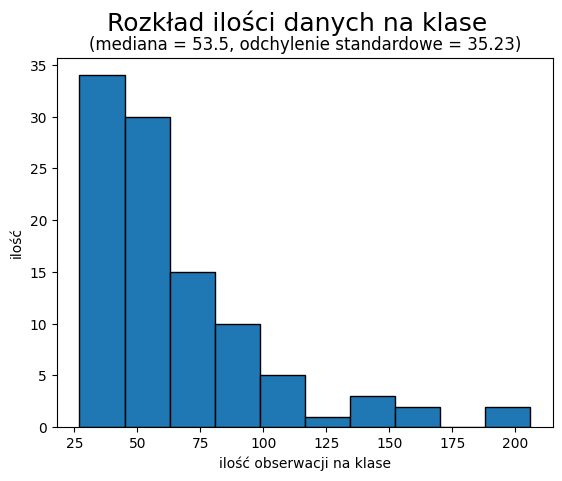

In [4]:
#plt.bar(x=range(1, len(class_sizes)+1),height=class_sizes)
plt.figure()
plt.hist(class_sizes, edgecolor="black")
plt.suptitle("Rozkład ilości danych na klase", fontsize=18)
plt.title(f"(mediana = {np.median(class_sizes)}, odchylenie standardowe = {round(np.std(class_sizes), 2)})", fontsize=12)
plt.xlabel("ilość obserwacji na klase")
plt.ylabel("ilość")
plt.savefig("plots/per_data.jpg")
plt.show()

duża część klas ma mniej niż 100 obserwacji, jednak część znacznie odstaje od mediany

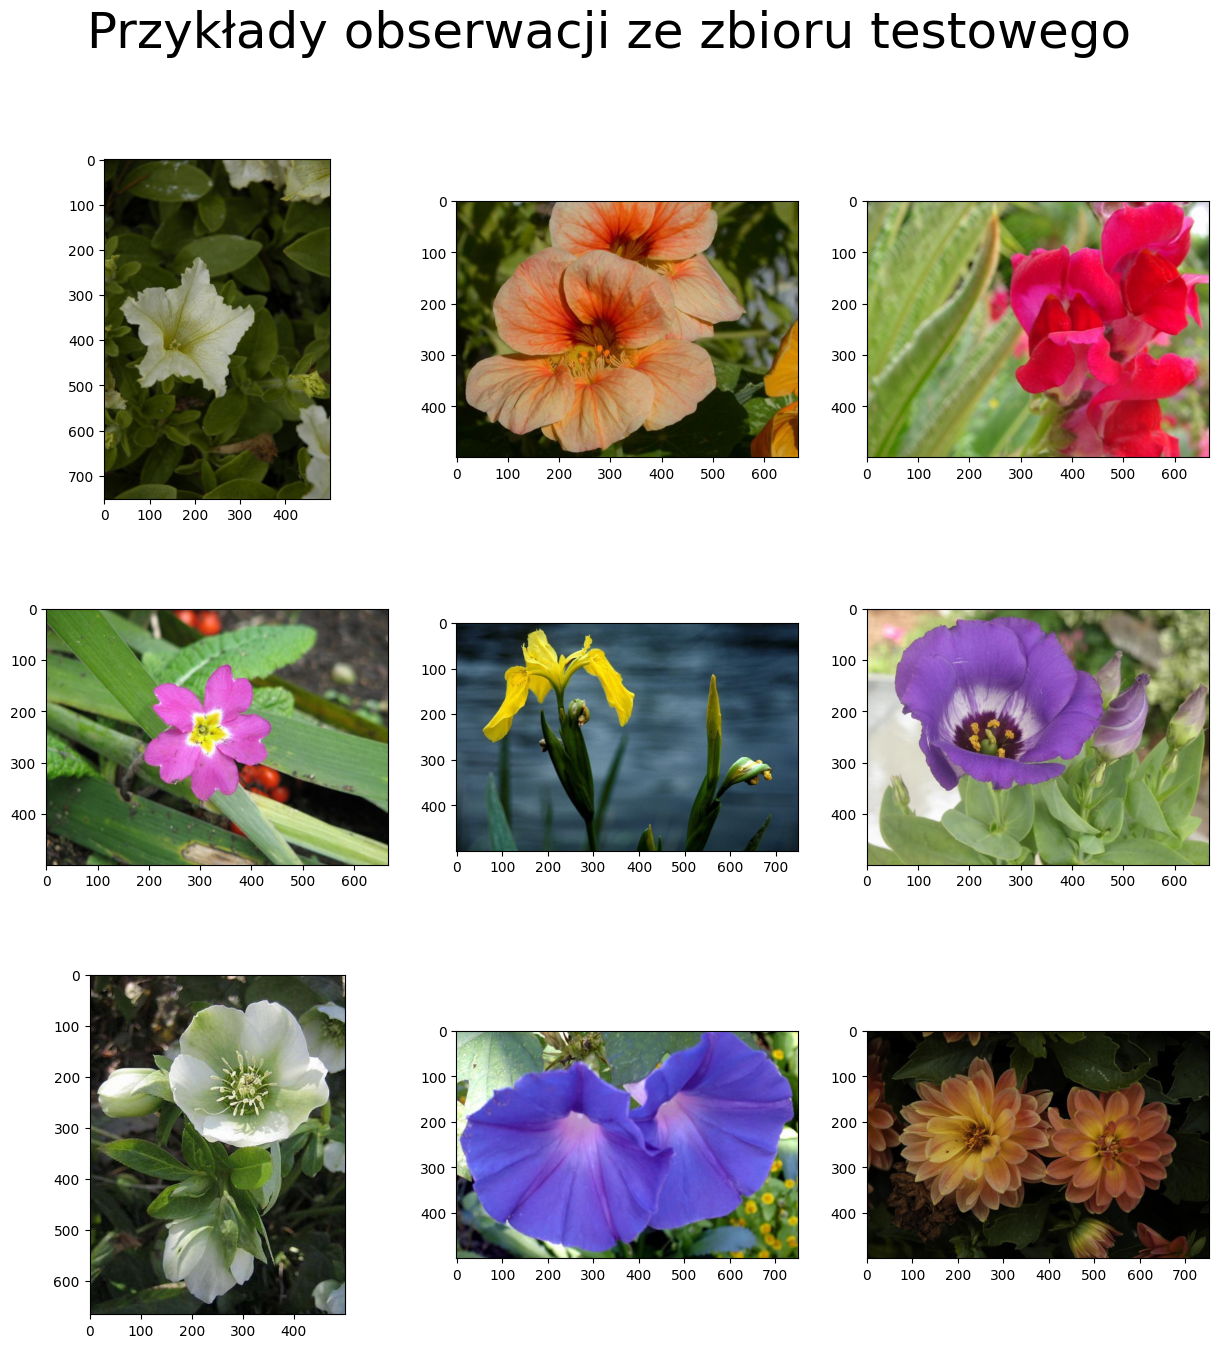

In [9]:
fig, ax = plt.subplots(3,3, figsize=(15,15))
img_list = os.listdir("test")

fig.suptitle("Przykłady obserwacji ze zbioru testowego", fontsize=36)

for col in range(3):
    for row in range(3):
        img = np.array(Image.open(os.path.join("test", random.choice(img_list))))
        ax[col, row].imshow(img)

plt.show()
fig.savefig("plots/image_sample.png")

### Zbadajmy teraz wielkości obrazków

In [29]:
## wielkość obrazka:
width = []
height = []
file_types = []
for class_dir in os.listdir(PATH):
    for object in os.listdir(os.path.join(PATH, class_dir)):
        w, h = imagesize.get(os.path.join(PATH, class_dir, object))
        width.append(w); height.append(h)

        file_types.append(object.split(".")[-1])

width = np.array(width)
height = np.array(height)

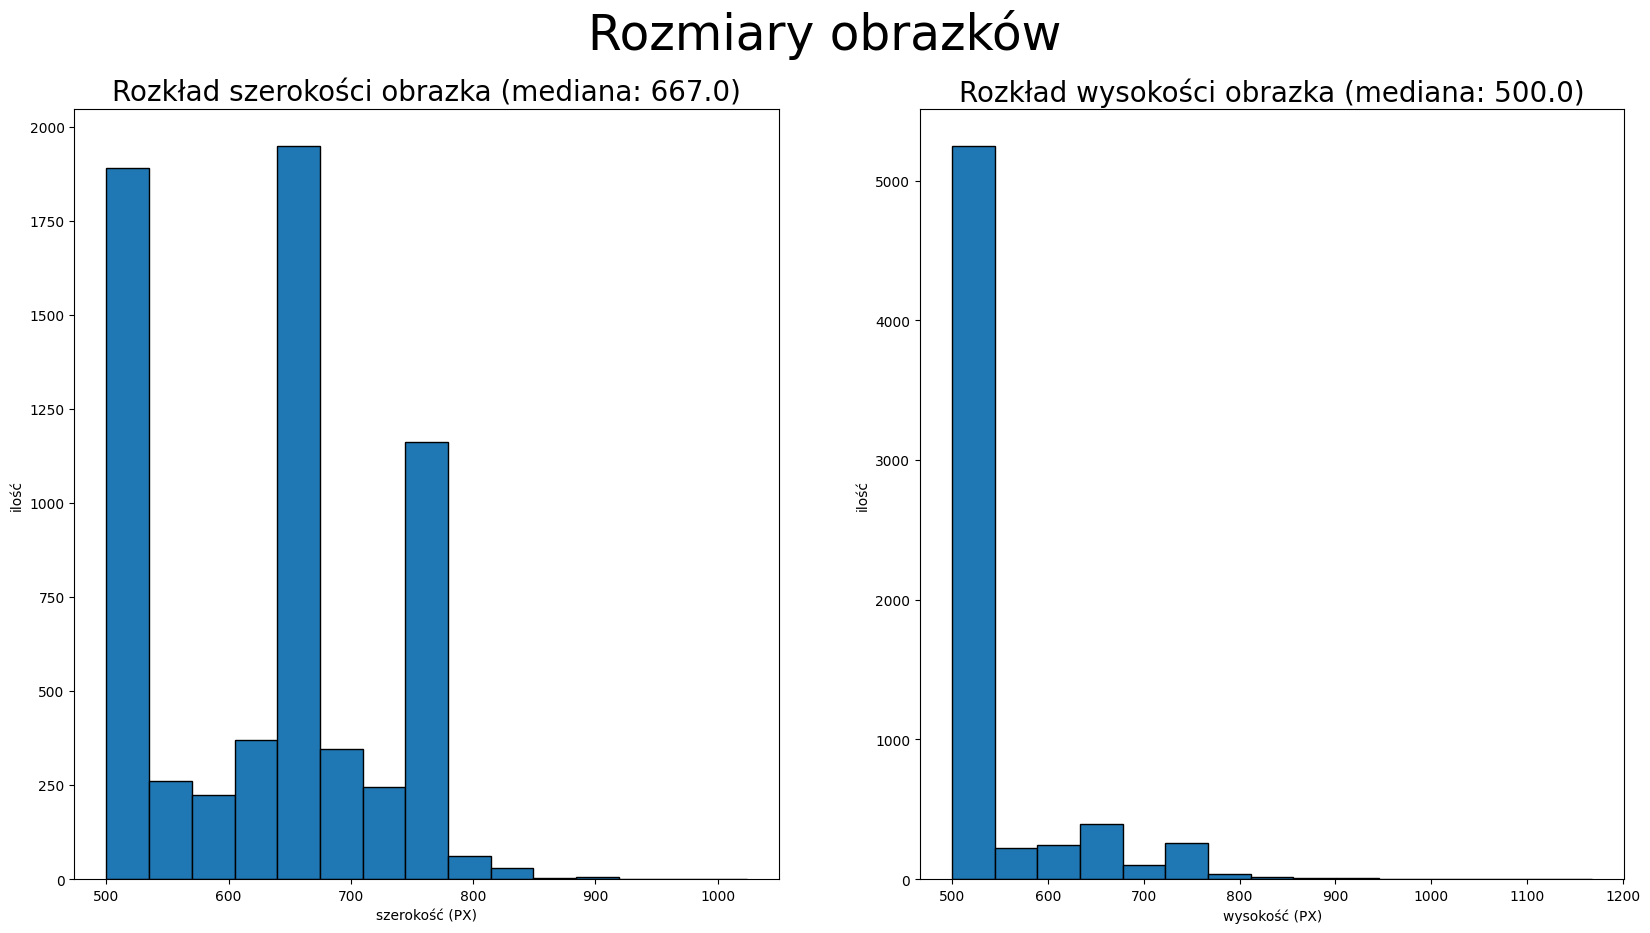

In [30]:
fig, ax = plt.subplots(1,2, figsize=(20,10))
fig.suptitle("Rozmiary obrazków", fontsize=35)
ax[0].hist(width, edgecolor="black", bins=15)
ax[0].title.set_text(f"Rozkład szerokości obrazka (mediana: {np.median(width)})")
ax[0].title.set_size(20)
ax[0].set_xlabel("szerokość (PX)")
ax[0].set_ylabel("ilość")

ax[1].hist(height, edgecolor="black", bins=15)
ax[1].title.set_text(f"Rozkład wysokości obrazka (mediana: {np.median(height)})")
ax[1].title.set_size(20)
ax[1].set_xlabel("wysokość (PX)")
ax[1].set_ylabel("ilość")

fig.savefig("plots/image_sizes.png")

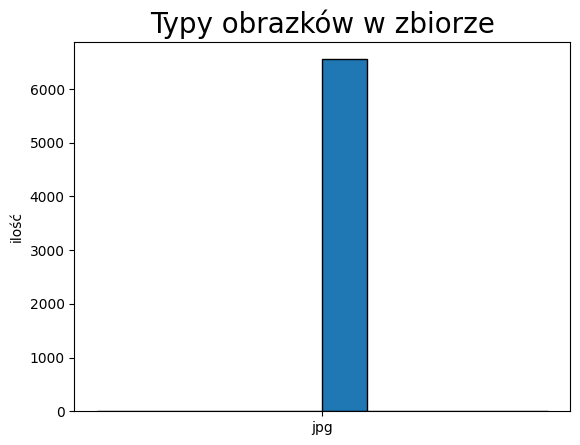

In [31]:
plt.hist(file_types, edgecolor="black")
plt.title("Typy obrazków w zbiorze", fontsize=20)
plt.ylabel("ilość")
plt.savefig("plots/image_types.png")

wszystkie zapisane obrazku są w formacie `.jpg`

# Analiza modelu

Sprawdźmy teraz jak działa model

In [32]:
# wczytajmy model
model = Model("test_dropout.json")
model.load_state_dict(torch.load("models/model_60.pt", weights_only=True))

# wyłączmy "tryb uczenia" naszej sieci
model.eval()

Model(
  (layers): ModuleList(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(3, 3), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout2d(p=0.1, inplace=False)
    (4): ReLU()
    (5): Conv2d(32, 64, kernel_size=(5, 5), stride=(3, 3), padding=(2, 2))
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Dropout2d(p=0.2, inplace=False)
    (9): ReLU()
    (10): Conv2d(64, 128, kernel_size=(5, 5), stride=(3, 3), padding=(2, 2))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Dropout2d(p=0.2, inplace=False)
    (14): ReLU()
    (15): Flatten(start_dim=1, end_dim=-1)
    (

## Trening modelu

![Tu miał być wykres model_plot.png, jak nie ma zobacz w folderze plots](plots/model_plot.png)

In [33]:
transforms = Compose([
    ToImage(),
    ToDtype(torch.float32, scale=True), # zmienia typ danych na float32 i normalizuje nam dane
    Resize((500,600)), # zmienia rozmiar obrazkana 500x600 (format wysokość x szerokość)
])

test_dataset = ImageFolder(root="valid", transform=transforms)
test_dataloader = DataLoader(test_dataset, batch_size=32)

In [34]:
confusion_matrix = torch.zeros((102, 102),dtype=torch.int)
for v_x, v_labels in test_dataloader:
    v_predictions = model.forward(v_x)

    v_predictions = torch.argmax(v_predictions, dim=1)

    for lab, pre in zip(v_labels, v_predictions):
        confusion_matrix[lab][pre] += 1

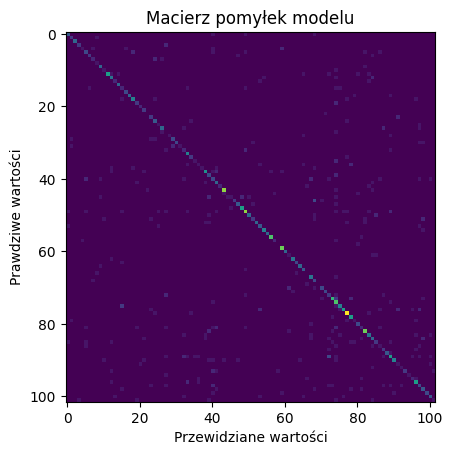

In [35]:
plt.imshow(confusion_matrix)
plt.ylabel("Prawdziwe wartości")
plt.xlabel("Przewidziane wartości")
plt.title("Macierz pomyłek modelu")
plt.savefig("plots/confusion_matrix.png")
plt.show()

Jak widać w niektórych klasach model ma 0 accuracy 

### Obliczmy teraz dokładność z podziałem na klase

In [36]:
acc = np.ndarray((102))
for n in range(102):
    acc[n] = confusion_matrix[n][n] / torch.sum(confusion_matrix[n])

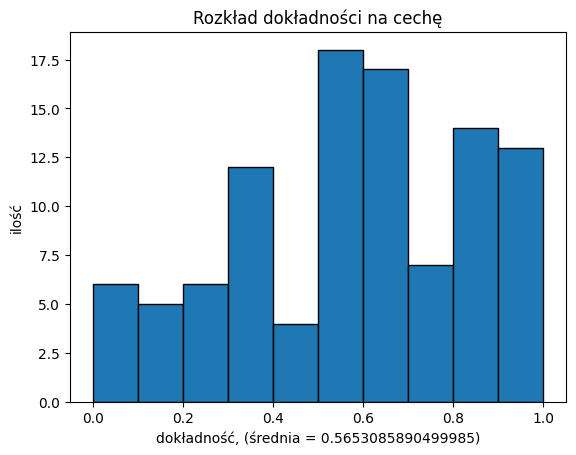

In [37]:
plt.hist(acc, bins=10, edgecolor="black")
plt.xlabel(f"dokładność, (średnia = {acc.mean()})")
plt.ylabel("ilość")
plt.title("Rozkład dokładności na cechę")

plt.savefig("plots/accuracy_distribution.png")
plt.show()

Koleracja między ilością próbek w danych i dokładnościa wynosi: 0.17186905657678203

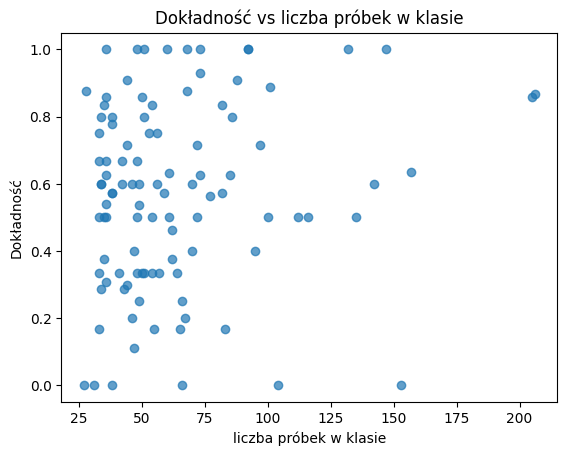

In [38]:
plt.scatter(class_sizes, acc, alpha=0.7)
plt.ylabel("Dokładność")
plt.xlabel("liczba próbek w klasie")
plt.title("Dokładność vs liczba próbek w klasie")

plt.savefig("plots/accuracy_vs_num_of_samples.png")

display(Markdown(f"Koleracja między ilością próbek w danych i dokładnościa wynosi: {np.corrcoef(acc, class_sizes)[0,1]}"))

plt.show()